$
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\R}{\mathcal{R}}
\DeclareMathOperator{\wv}{\mathbf{w}}
\newcommand{\bm}{\boldsymbol}
$

# ITCS 6010: Assignment #3 (V1)

<font color="red">(Due: 11 pm on Dec 3rd) </font>

### 1. The value of an action, $Q^\pi(s,a)$, depends on the expected next reward and the expected sum of the remaining rewards. Again we can think of this in terms of a small backup diagram, this one rooted at an action (state–action pair) and branching to the possible next states:

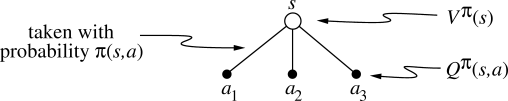

### Give the equation corresponding to this intuition and diagram for the value at the root node, $V^\pi(s)$, in terms of the value at the expected leaf node, $Q^\pi(s,a)$, given $s_t =s$. This expectation dpends on the policy, $\pi$. Then give a second equation in which the expected value is written out explicitly in terms of $\pi(a|s)$ such that no expected value notation appears in the equation.

$$V^{\pi}(s)=\mathbb{E}_{\pi}[Q^{\pi}(s, a)~|~s_t=s]$$<br>
$$V^{\pi}(s)=\sum_{a} \pi(a | s)Q^{\pi}(s, a)$$

### 2. The compatible function approximation theorem states that the value function approximator is compatible to the policy, i.e., $\nabla_{\wv} Q_{\wv}(s,a) = \nabla_{\bm\theta} \log \pi_{\bm\theta}(s,a)$, and its parameter $\wv$ minimizes the mean-square error,  $\E_{\pi_{\bm\theta}} \big[\big(Q^{\pi_\theta}(s,a) - Q_{\wv}(s,a) \big)^2 \big]$. Then the policy gradient is exact,  $ \nabla_{\bm\theta} J(\bm\theta) = \E_{\pi_{\bm\theta}} \big[ \nabla_{\bm\theta} \log \pi(a | s, \bm\theta) Q_{\wv} (s, a) \big]$. Show your proof.

If we minimize parameters $\bf{w}$ with repect to the mean squared error:
$$m = \E_{\pi_{\bm\theta}} \big[\big(Q^{\pi_\theta}(s,a) - Q_{\wv}(s,a) \big)^2 \big]$$
Then we are moving in the direction where:
$$\nabla_{\bf{w}} m=0$$
As such, we rewrite the expectation:
$$\mathbb{E}_{\pi_{\theta}}\left[\left(Q^{\pi_\theta}(s, a)-Q_{\bf{w}}(s, a)\right) \nabla_{\bf{w}} Q_{\bf{w}}(s, a)\right]=0$$
$$\mathbb{E}_{\pi_{\theta}}\left[\left(Q^{\pi_\theta}(s, a)-Q_{\bf{w}}(s, a)\right) \nabla_{\theta} \log \pi_{\theta}(s, a)\right]=0$$
$$\mathbb{E}_{\pi_{\theta}}\left[Q^{\pi_\theta}(s, a) \nabla_{\theta} \log \pi_{\theta}(s, a)\right]=\mathbb{E}_{\pi_{\theta}}\left[Q_{\bf{w}}(s, a) \nabla_{\theta} \log \pi_{\theta}(s, a)\right]$$
<br>Therefore, we can then substitute $Q^{\pi_\theta}(s, a)$ with $Q_{\wv} (s, a)$ in the policy gradient:
$$\nabla_{\bm\theta} J(\bm\theta) = \E_{\pi_{\bm\theta}} \big[ \nabla_{\bm\theta} \log \pi(a | s, \bm\theta) Q_{\wv} (s, a) \big]$$

### 3. (Programming) 
1) Implement REINFORCE with Baseline (Value function for advantage) with neural network policy approximation to solve the Maze problem. 

2) Now, implement AC Methods with NN approximators for both actor and critic to solve the Maze problem. How are the solutions different each other?

#### Maze Problem (Practice)

In [60]:
import collections
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
from collections import defaultdict
import random
import math
import torch
from statistics import mean
import torch.nn.functional as F

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [61]:
%%bash 
cat ../grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO


### GridWorld Class


In [62]:
# maze example
#This environment is from the course material at: 
#https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6010/notebooks/assign/Assign3.ipynb
class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [63]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [64]:
class Policy(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super(Policy, self).__init__()
        #input:state
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(hidden_size, output_size)
        self.out = torch.nn.Softmax(dim=0)
        #output: action probabilities
        
    def forward(self, x):
        x = torch.from_numpy(x).float()
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.out(x)
        return x

    def update(self, advantage, action_prob, optimizer):
        #policy_net.update(advantage, action_prob)
        loss = -(torch.log(action_prob)*advantage).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def policy_init(input_size, hidden_size, output_size, lr):
    model = Policy(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    return model, optimizer

In [65]:
class Value(torch.nn.Module):   
    def __init__(self,input_size, hidden_size, output_size):
        super(Value, self).__init__()
        #input:state
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(hidden_size, output_size)
        #output: value
        
    def forward(self, x):
        x = torch.from_numpy(x).float()
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

    def update(self, advantage, optimizer):
        #value_net.update(baseline_value, G_t)
        loss = advantage.pow(2).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

def value_init(input_size, hidden_size, output_size, lr):
    model = Value(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    return model, optimizer

In [76]:
def policy_gradient(num_episodes=20000, epsilon=1, final_epsilon=0.1, gamma=0.9, lr=0.002, algo='rf'):
    terminal_state_indicators = ["H","N","F","G"]

    policy_net, pol_opt = policy_init(2,20,len(env._actions),lr)
    policy_net.train()
    value_net, val_opt = value_init(2,20,1,lr)
    value_net.train()
    
    epsilon_decay =  np.exp(np.log(final_epsilon) / num_episodes)

    all_Gt = []
    all_avg = []
    for ep in range(0, num_episodes):
        reward_sum = 0
        episode = []
        #Randon Starts
        start_row = random.randint(0,env._size[0])
        start_col = random.randint(0,env._size[1])
        if(env.check_state([start_row,start_col]) == 'O' and (np.random.rand() < epsilon)):
            env.init([start_row,start_col])
        else:
            env.init([0,0])
        done = 0
        for steps in range(0,100):
            state = env.get_cur_state()
            action_probs = policy_net.forward(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs.detach().numpy())

            reward = env.next(action)
            reward_sum += reward
            next_state = env._s
            curr = env.check_state(next_state)
            if(curr in terminal_state_indicators):
                done = 1  
            #store experience
            episode.append((state, action, reward, action_probs[action], next_state))
            #if done, break
            if done:
                break
            state = next_state

        all_Gt.append(reward_sum)
        step_count = 0
        advantages = []
        picked_actp = []
        for traj in episode:
            state = traj[0]
            action = traj[1]
            action_prob = traj[3]
            next_state = traj[4]
            if(algo=='rf'):
                G_t = 0
                for i in range(step_count, len(episode)):
                    reward = episode[i][2]
                    G_t += reward*(gamma**(i-step_count))
            elif(algo=='ac'):
                reward = traj[2]
                G_t = reward + gamma*value_net.forward(next_state).detach()
            else:
                print("Invalid algorithm: Use 'rf' or 'ac'")
            baseline_value = value_net.forward(state)
            advantage = G_t - baseline_value
            advantages.append(advantage)
            picked_actp.append(action_prob)
            step_count += 1
        value_net.update(torch.stack(advantages), val_opt)
        policy_net.update(torch.stack(advantages), torch.stack(picked_actp), pol_opt)
        epsilon *= epsilon_decay
        avg = mean(all_Gt[max(-50,-len(all_Gt)):])
        all_avg.append(avg)
        if ep>50 and avg > 20:
            print('Converged in episode '+str(ep))
            break
    return policy_net, all_Gt, all_avg

In [77]:
def print_policy(policy):
    print_value = np.zeros((env._size[0],env._size[1]))
    bad_state_indicators = ["H","N","F"]
    policy.eval()
    for row in range(0,env._size[0]):
        for col in range(0,env._size[1]):
            state = np.asarray([row,col])

            action_probs = policy.forward(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs.detach().numpy())
            curr = env.check_state(state)
            if(curr in bad_state_indicators):
                print_value[tuple(state)] = 0
            elif(curr in "G"):
                print_value[tuple(state)] = 9
            else:
                print_value[tuple(state)] = int(action)+1
    print("0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal")
    print(print_value)

In [78]:
np.set_printoptions(suppress=True)
env = GridWorld("../grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


Converged in episode 13772
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 4. 4. 4. 4. 4.]
 [4. 4. 1. 0. 4. 4. 0. 4. 4.]
 [2. 4. 4. 4. 4. 4. 0. 1. 4.]
 [2. 2. 4. 4. 0. 0. 0. 1. 4.]
 [3. 2. 0. 2. 4. 4. 4. 1. 0.]
 [3. 3. 0. 2. 2. 2. 9. 4. 1.]
 [3. 3. 2. 2. 2. 2. 2. 2. 3.]]
Final Average Reward:   20.02


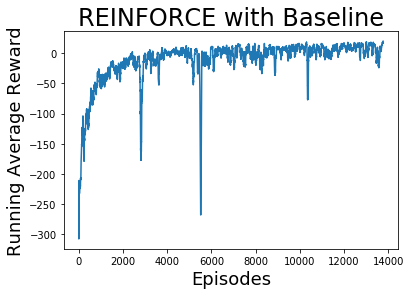

In [81]:
#******************* REINFORCE with Baseline ********************************
policy, all_reward, avg_reward = policy_gradient(num_episodes=20000, epsilon=1,
                                        final_epsilon=0.8,gamma=0.99, lr=0.002, algo='rf')
print_policy(policy)
plt.plot(avg_reward)
plt.title('REINFORCE with Baseline', fontsize=24)
plt.ylabel('Running Average Reward', fontsize=18)
plt.xlabel('Episodes', fontsize=18)
print("Final Average Reward:   " + str(avg_reward[-1]))
plt.show()

Converged in episode 17573
0: Hole    1: Left    2: Right    3: Up    4: Down    9: Goal
[[4. 4. 4. 0. 4. 4. 4. 4. 4.]
 [4. 4. 4. 0. 4. 4. 0. 4. 4.]
 [2. 2. 4. 4. 4. 4. 0. 4. 4.]
 [2. 2. 2. 4. 0. 0. 0. 4. 4.]
 [2. 2. 0. 2. 2. 4. 4. 4. 0.]
 [2. 2. 0. 2. 2. 2. 9. 4. 4.]
 [2. 2. 2. 2. 2. 2. 2. 2. 4.]]
Final Average Reward:   20.1


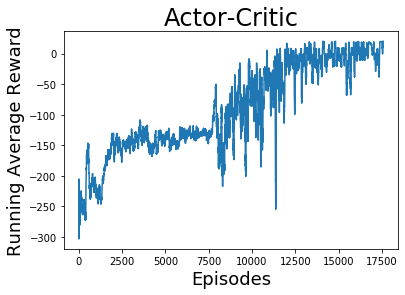

In [82]:
#******************* Actor-Critic ********************************
policy, all_reward, avg_reward = policy_gradient(num_episodes=20000, epsilon=0.5,
                                        final_epsilon=0.1, gamma=0.99, lr=0.002, algo='ac')
print_policy(policy)
plt.plot(avg_reward)
plt.title('Actor-Critic', fontsize=24)
plt.ylabel('Running Average Reward', fontsize=18)
plt.xlabel('Episodes', fontsize=18)
print("Final Average Reward:   " + str(avg_reward[-1]))
plt.show()

The generic policy update for REINFORCE with Baseline is shown in the follwing equation:<br><br>
$$\theta_{t+1}= \theta_t + \alpha\left(G_{t}-\hat{V}\left(s_{t}\right)\right) \nabla_{\theta} \log \pi_{\theta}\left(s_{t}, a_{t}\right)$$
Where $\alpha$ is the learning rate, and $\theta$ represents the policy function parameters.

Here, we see that REINFORCE with Baseline takes the true return $G_t$, and subtracts the approximated value $\hat{V}\left(s_{t}\right)$ as the baseline. This forms its advantage, which is used to push the gradient with respect to the difference in the true return and approximated state value.<br><br>

Basic Actor-Critic is different than REINFORCE with Baseline in its advantage, as shown in the following equation:<br>

$$\theta_{t+1}= \theta_t + \alpha\left(r + \gamma \hat{V}\left(s_{t+1}\right)-\hat{V}\left(s_{t}\right)\right) \nabla_{\theta} \log \pi_{\theta}\left(s_{t}, a_{t}\right)$$

Here, we can see that the advantage is calculated with the TD error using the value function approximate for the next state, rather than the full return used by REINFORCE.